In [1]:
import xml.etree.ElementTree as ET
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from skimage.util import img_as_float
from skimage import io, color
import skimage
from scipy import misc
from skimage.segmentation import slic, mark_boundaries
import cv2
import matplotlib.pyplot as plt
import pickle
from os import listdir, rename
from os.path import isfile, join

In [2]:
'''
Given XML file, gets the xy positions for text block
'''
def get_xy_coordinates(filename):    
    # Give location of XML document
    tree = ET.parse(filename)
#     tree = ET.parse('d-006_kai.chen@unifr.ch.xml')
    root = tree.getroot()

    # Get the page
    for child in root:
        if child.tag == 'Page':
            page = child

    # Identify all (x,y) corresponding to text blok
    coordinates_extended = []
    coordinates_appended = []
    for region in page.findall('TextRegion'):
        coords = region.find('Coords')
        label = region.get('type')
        if label=='text':
#             labels.append(label)
            xy = []
            for point in coords.findall('Point'):
                x = int(point.get('x'))
                y = int(point.get('y'))
                x = x*0.125
                y = y*0.125
                xy.append((x,y))
            coordinates_extended.extend(xy)
            coordinates_appended.append(xy)
    # return
    return coordinates_extended, coordinates_appended

In [3]:
'''
Reads the image and scales it by a factor of 2^-3
'''
def read_image(img_file):
    # Read input image
    image = img_as_float(io.imread(img_file))
    image = color.rgb2gray(io.imread(img_file))
    image = misc.imresize(image, 0.125, interp='nearest', mode=None)
    # plt.imshow(image, cmap='gray')
    # plt.show()
    return image

In [4]:
'''
Creat image segments using SLIC.
Returns: mask and the pixel intensities for every region.
'''
def SLIC(num, image):
    masks = []
    Regions = []
    segments = slic(image, n_segments = num)
    
    for (i, segVal) in enumerate(np.unique(segments)):
        # construct a mask for the segment
        mask = np.zeros(image.shape[:2], dtype = "uint8")
        mask[segments == segVal] = 255
        seg = cv2.bitwise_and(image, image, mask = mask)
        r = cv2.bitwise_and(image, image, mask = mask)
        masks.append(mask)
        Regions.append(r)
    masks = np.array(masks)
    Regions = np.array(Regions)
    return masks, Regions, segments

In [5]:
def view_segments(image, segments):
    fig = plt.figure("Superpixels -- %d segments" % (1000))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")

    # show the plots
    plt.show()

In [6]:
'''
Get input images (kxk) for the CNN and their borders
'''
def get_images_borders_old(Regions, total_rows, k, total_cols):
    input_images = []
    all_coordinates = []
    all_coordinates_extened = []
    i = 0
    for r in range(0,total_rows-(2*k)+1,k):
        for c in range(0,total_cols-(2*k)+1,k):
            input_images.append(Regions[i][r:r+k,c:c+k])
            all_coordinates.append([(r,c),(r,c+k-1),(r+k-1,c+k-1),(r+k-1,c)])
            i += 1
                
#     all_coordinates = np.array(all_coordinates)
    input_images = np.array(input_images)
    return input_images, all_coordinates
    
    input_images_f = []
    all_coordinates_f = []
    # Remove all zero images
    for j in range(len(input_images)):
        if not (input_images[j]==0).all():
            input_images_f.append(input_images[j])
            all_coordinates_f.append(all_coordinates[j])
            all_coordinates_extened.extend(all_coordinates[j])
    return input_images_f, all_coordinates_f, all_coordinates_extened

In [7]:
'''
Get input images (kxk) for the CNN and their borders
'''
def get_images_borders(image, total_rows, k, total_cols):
    input_images = []
    all_coordinates = []
    all_coordinates_extened = []
    i = 0
    for r in range(0,total_rows-(2*k)+1,k):
        for c in range(0,total_cols-(2*k)+1,k):
            input_images.append(image[r:r+k,c:c+k])
            all_coordinates.append([(r,c),(r,c+k-1),(r+k-1,c+k-1),(r+k-1,c)])
            i += 1
                
#     all_coordinates = np.array(all_coordinates)
    input_images = np.array(input_images)
#     print r+k
#     print c+k
    return input_images, all_coordinates
    
#     input_images_f = []
#     all_coordinates_f = []
#     # Remove all zero images
#     for j in range(len(input_images)):
#         if not (input_images[j]==0).all():
#             input_images_f.append(input_images[j])
#             all_coordinates_f.append(all_coordinates[j])
#             all_coordinates_extened.extend(all_coordinates[j])
#     return input_images_f, all_coordinates_f, all_coordinates_extened

In [8]:
def make_training_data(input_images, all_coordinates, xy_append):
    training_data = [] # col 0 : Image, col 1 : Label;  Label = 1 => Text
    for i in range(len(all_coordinates)):
        data = []
        coordinate = all_coordinates[i]
        img = input_images[i]
        data.append(img)
        label = 0
        for coord in coordinate:
            point = Point(coord)
            for text_block in xy_append:
                polygon = Polygon(text_block) 
                if polygon.contains(point):
                    label = 1
                    break
            if label == 1:
                break
        data.append(label)
        training_data.append(data)
    training_data = np.array(training_data)
    return training_data

In [9]:
'''
Calling Functions
'''
def call_functions(train_pair):
    train_data = []
    for pair in train_pair:
        img_path = pair[0]
        xml_path = pair[1]
        image = read_image(img_path) # Read Image
        masks, Regions, segments = SLIC(500, image) # Perform SLIC into 1000 segments
        # view_segments(image, segments) # To Plot segments
        xy_extend, xy_append = get_xy_coordinates(xml_path) # Get (x,y) from the xml file
        k = np.count_nonzero(masks[0][0]) # Get dimension of input image (kxk)
        total_rows = Regions.shape[1]
        total_columns = Regions.shape[2]
#         print Regions.shape
#         input_images, all_coordinates, all_coordinates_extened = get_images_borders(Regions, total_rows, k, total_columns)
        input_images, all_coordinates = get_images_borders(image, total_rows, k, total_columns)
        ims = np.array(input_images)
#         print ims.shape
        ac = np.array(all_coordinates)
#         print ac.shape
        training_data = make_training_data(input_images, all_coordinates, xy_append)
        train_data.extend(training_data)
    return train_data

In [10]:
def view_segments(input_images):
    f, axarr = plt.subplots(10, 10)
    for i in range(100):
        axarr[i/10,i%10].imshow(input_images[i+30], interpolation='bilinear', cmap='gray')
    plt.show()

In [11]:
image_path = './page_images'
imageFiles = [image_path + '/' + f for f in listdir(image_path) if isfile(join(image_path, f)) and not f.startswith(".")]

training_truth_path = './ground-truth/training'
trainingFiles = [training_truth_path + '/' + f for f in listdir(training_truth_path) if isfile(join(training_truth_path, f)) and not f.startswith(".")]

validation_truth_path = './ground-truth/validation'
validationFiles = [validation_truth_path + '/' + f for f in listdir(validation_truth_path) if isfile(join(validation_truth_path, f)) and not f.startswith(".")]

test_truth_path = './ground-truth/test'
testFiles = [test_truth_path + '/' + f for f in listdir(test_truth_path) if isfile(join(test_truth_path, f)) and not f.startswith(".")]

In [12]:
def make_pair(trainingFiles, margin):
    train_pair = []
    for path in trainingFiles:
        image = './page_images' + path[15+margin:21+margin] + '.jpg'
        train_pair.append((image, path))
    return train_pair

In [13]:
train_pair = make_pair(trainingFiles, len("training"))
train_data = call_functions(train_pair)
len(train_data)

/Users/poorvarane/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


10400

In [14]:
test_pair = make_pair(testFiles, len("test"))
test_data = call_functions(test_pair)

/Users/poorvarane/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [15]:
validation_pair = make_pair(validationFiles, len("validation"))
validation_data = call_functions(validation_pair)

/Users/poorvarane/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [ ]:
# '''
# To Dump or load from pickle files
# '''
# pickle_file = open('validation_data.pkl', 'wb')
# pickle.dump(validation_data, pickle_file)
# pickle_file.close()
# pickle_file = open('test_data.pkl', 'wb')
# pickle.dump(test_data, pickle_file)
# pickle_file.close()
# pickle_file = open('train_data.pkl', 'wb')
# pickle.dump(train_data, pickle_file)
# pickle_file.close()
# # input_images = pickle.load(open('input_images.pkl','r'))
# # all_coordinates = pickle.load(open('all_coordinates.pkl','r'))
# # training_data = pickle.load(open('training_data.pkl','r'))

In [ ]:
len(test_data)

In [ ]:
test_data = np.array(test_data)
print test_data[0][0]
test_data[0][0].shape

In [ ]:
plt.imshow(train_data[0][0], interpolation='nearest', cmap = 'gray')
plt.show()

In [ ]:
train_data[0][0] = np.array(train_data[0][0])
len(train_data)

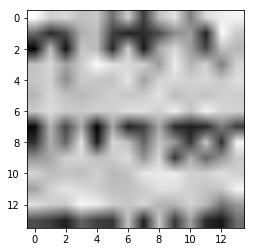

1


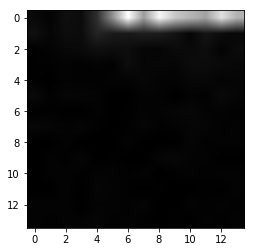

0


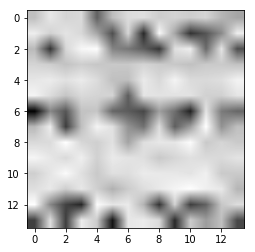

0


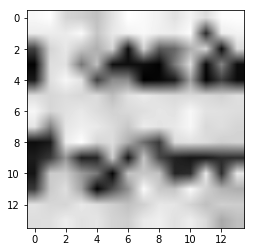

1


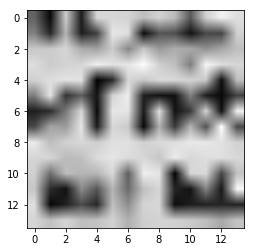

0


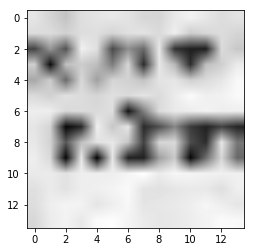

1


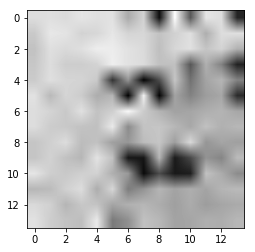

0


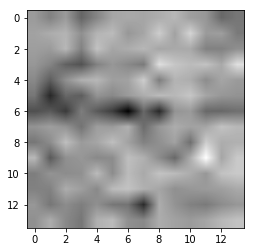

0


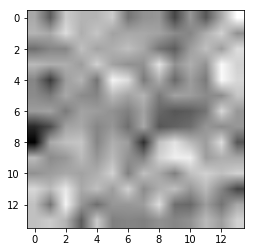

0


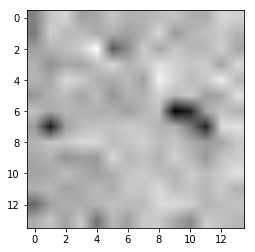

1


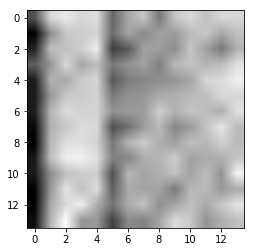

0


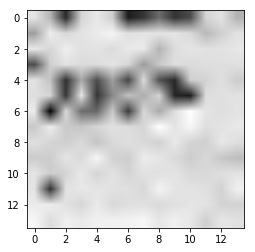

0


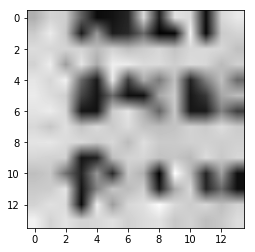

0


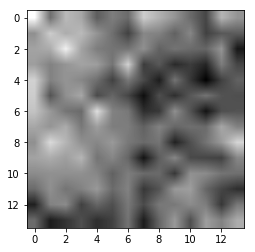

0


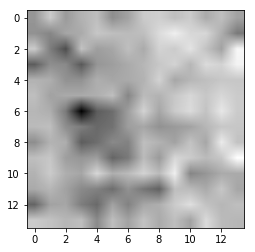

1


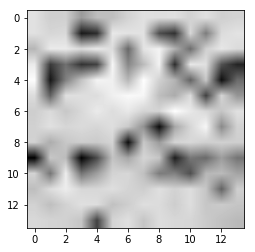

0


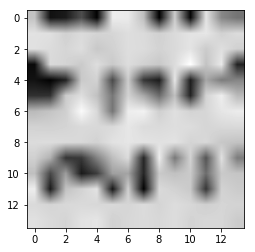

1


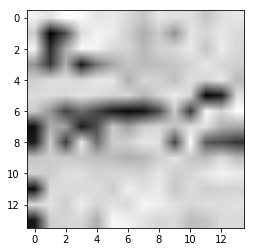

1


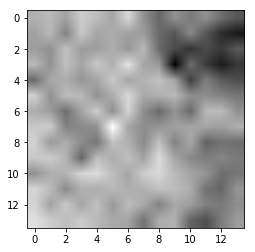

1


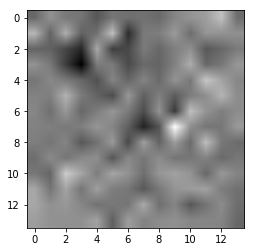

0


In [16]:
for i in np.random.choice(len(train_data), 20):
    plt.imshow(train_data[i][0], interpolation='bilinear', cmap = 'gray')
    plt.show()
    print(train_data[i][1])